In [170]:
from unstructured.partition.auto import partition
from unstructured.partition.pdf import partition_pdf
from google import genai
from google.genai import types
import numpy as np
import chromadb
from dotenv import load_dotenv, dotenv_values

### Data Extraction from PDF

In [171]:
file_path = 'examples/maxwell-ems-school-improvement-2023.pdf'

elements = partition_pdf(
    filename=file_path, 
    strategy='hi_res',
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
    )

In [172]:
set([str(type(el)) for el in elements])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [173]:
# Each element is a chunk represented by a CompositeElement, which is used to store multiple elements of different types (Text, Image, Table, etc.)
for el in elements:
    print(type(el))
    print(el.to_dict())
    

<class 'unstructured.documents.elements.CompositeElement'>
{'type': 'CompositeElement', 'element_id': '8f66703fe2f955c3a7969d57acfd120e', 'text': 'Southeast District Cre Together We Serve\n\nMAXWELL SCHOOL IMPROVEMENT PLAN\n\nMaxwell Eagles S.O.A.R.\n\nSEPTEMBER 1, 2023\n\nDR. HYDE, PRINCIPAL; MR. EL-SHAAKIR, ASSISTANT PRINCIPAL DoDEA Americas Southeast District\n\nSchool Improvement Plan Framework\n\nVision/Mission\n\nThis document is Maxwell’s School Improvement Plan (SIP). The Plan is a roadmap and means to achieve the school’s vision and the attendant goals that follow from it. The vision, which follows directly from the District Improvement Plan (DIP), focuses on students, staff, and parents, which are three primary school stakeholders. The vision addresses broad, important outcomes for each group; they are achieving students, thriving staff, and engaged parents. The Plan also has a mission statement that guides the development of the strategies and actions necessary to achieve th

In [174]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

for el in elements:
    pp.pprint(el.metadata.orig_elements)
    print("*" * 100)

[   <unstructured.documents.elements.Image object at 0x7d00dbe06480>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d00dbe04560>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d00dbe3e240>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d00dbe3d790>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d00db93b500>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7d00db93ae10>,
***************************************************************************

In [175]:
# Looking at the extracted tables

original_elements = []

for el in elements:
    original_elements += el.metadata.orig_elements
    
tables = [el for el in original_elements if 'Table' in str(type(el))]
tables_html = [el.metadata.text_as_html for el in original_elements if 'Table' in str(type(el))]

for i in range(len(tables)):
    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/tables/table_{i}.html", 'w')
    f.write(tables_html[i])
    f.close

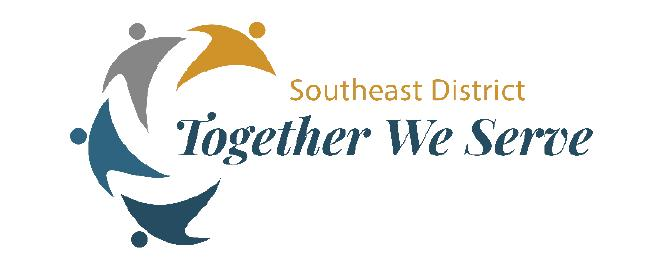

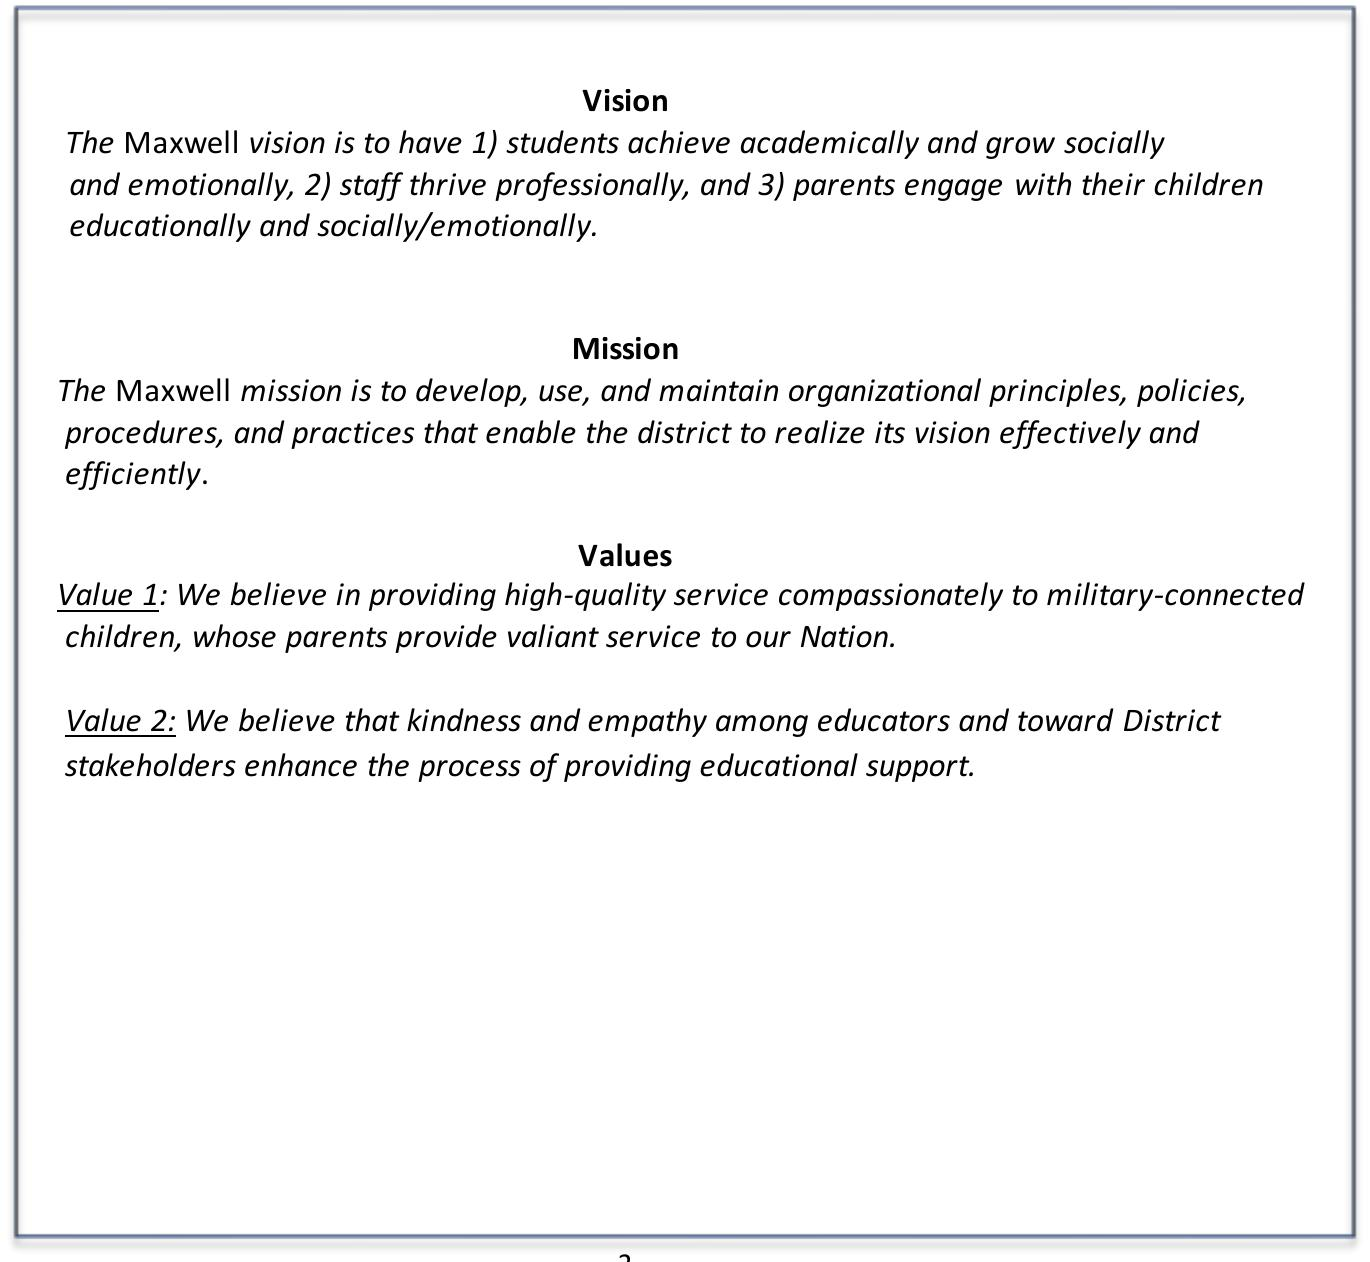

In [176]:
import base64
from IPython.display import Image, display

def display_image(image_base64):
    img_data = base64.b64decode(image_base64)
    display(Image(data=img_data))

    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/images/image_{i}.webp", 'wb')
    f.write(img_data)
    f.close

images = [el.metadata.image_base64 for el in original_elements if 'Image' in str(type(el))]

for i in range(len(images)):
    display_image(images[i])

In [177]:
texts = [el for el in elements if 'CompositeElement' in str(type(el))]

for text in texts:
    print(text)
    print('*' * 100)

Southeast District Cre Together We Serve

MAXWELL SCHOOL IMPROVEMENT PLAN

Maxwell Eagles S.O.A.R.

SEPTEMBER 1, 2023

DR. HYDE, PRINCIPAL; MR. EL-SHAAKIR, ASSISTANT PRINCIPAL DoDEA Americas Southeast District

School Improvement Plan Framework

Vision/Mission

This document is Maxwell’s School Improvement Plan (SIP). The Plan is a roadmap and means to achieve the school’s vision and the attendant goals that follow from it. The vision, which follows directly from the District Improvement Plan (DIP), focuses on students, staff, and parents, which are three primary school stakeholders. The vision addresses broad, important outcomes for each group; they are achieving students, thriving staff, and engaged parents. The Plan also has a mission statement that guides the development of the strategies and actions necessary to achieve the vision. Finally, two value statements reflect the school’s purpose and beliefs, which are to deliver high- quality service with empathy and kindness.

Vision T

In [178]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

summarization_model = ChatOpenAI(model="gpt-4o")

text_table_summarization_prompt = ChatPromptTemplate.from_template(
    """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additional comment.
    Do not start your message by saying "Here is a summary" or anything like that.
    Just give the summary as it is.

    Table or text chunk: {element}
    """
)

text_table_summarize_chain = {"element": lambda x: x} | text_table_summarization_prompt | summarization_model | StrOutputParser()

img_summarization_prompt_text = """Describe the image in detail. For context,
                  the image is part of a school district's improvement plan document.
                  Be specific about graphs and text content.
                  Respond only with the description of the image, no additional comment.
                  """

img_summarization_messages = [
    (
        "user",
        [
            {
                "type": "text",
                "text": img_summarization_prompt_text
            },
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"}
            }
        ]
    )
]

img_summarization_prompt = ChatPromptTemplate.from_messages(img_summarization_messages)

img_summarize_chain = img_summarization_prompt | summarization_model | StrOutputParser()

In [179]:
text_summaries = text_table_summarize_chain.batch(texts)
pp.pprint(text_summaries)

[   'The Maxwell School Improvement Plan focuses on achieving its vision '
    'through the collaboration of students, staff, and parents. The vision '
    "emphasizes students' academic, social, and emotional growth, staff's "
    "professional thriving, and parents' educational and social engagement "
    'with their children. The mission is to maintain effective organizational '
    'practices to realize the vision. The values include providing '
    'compassionate, high-quality service to military-connected children and '
    'fostering kindness and empathy among educators and stakeholders.',
    "The Plan's content outlines goals related to three vision components: "
    'student achievement in math, literacy, and social/emotional health; staff '
    'pedagogical skills and social/emotional health; and parent engagement in '
    "children's learning. Strategies are theory-based and linked to goals, "
    'supported by action plans. Goal areas include math and ELA achievement, '
  

In [180]:
table_summaries = text_table_summarize_chain.batch(tables)
pp.pprint(table_summaries)

[   'The table outlines various goals and objectives in education, focusing on '
    'academic growth and emotional well-being across three main perspectives: '
    'students, staff, and parents. Key areas include math and ELA achievement, '
    'social/emotional development, and teacher pedagogy. Specific performance '
    'metrics are highlighted, such as a 64% goal for writing objectives, with '
    'current achievements in written expression at 75% and language '
    'conventions at 76%. Parent and faculty involvement is measured through '
    'survey questions, with varying levels of engagement indicated. Additional '
    'targeted support strategies and communication plans are mentioned for '
    'school-based improvement, focusing on writing and mathematical practice.',
    "The students' goals focus on achieving high academic performance in CCRS "
    'Literacy and Math. For literacy, the average score rose slightly from 35 '
    'to 36 between SY 20/21 and SY 22/23, which rema

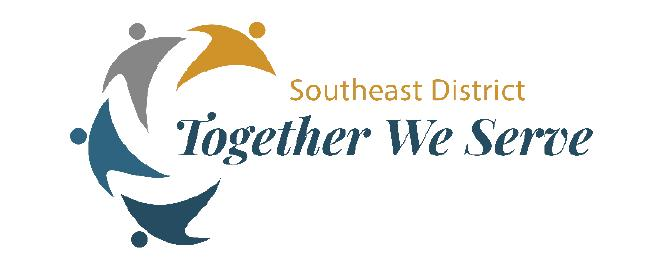

The image features a logo with the text "Southeast District" in an amber color, positioned above the larger text "Together We Serve" in a blue, serif font. To the left of the text is a circular design composed of stylized human figures in different colors: dark gray, amber, and two shades of blue. The figures form a circle by interlinking hands and feet, symbolizing unity and collaboration.


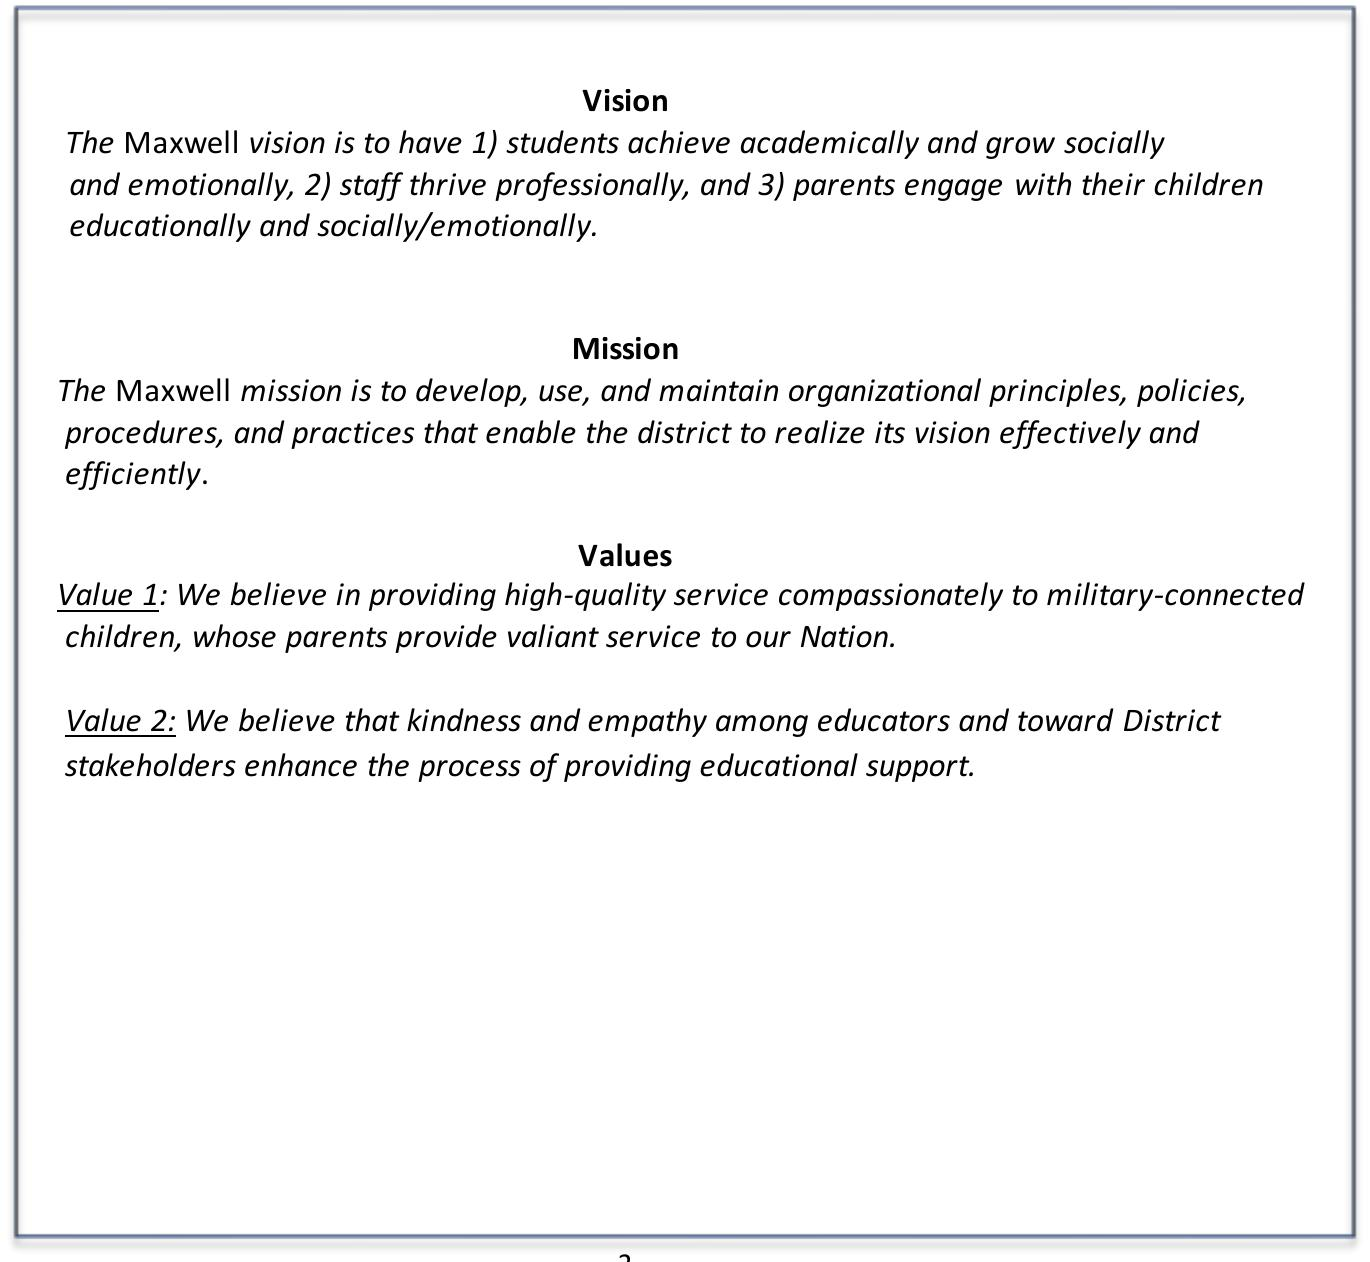

The image contains a section from a document titled "Vision, Mission, and Values" for Maxwell. It includes the following text:

**Vision:**
- The Maxwell vision is to have 1) students achieve academically and grow socially and emotionally, 2) staff thrive professionally, and 3) parents engage with their children educationally and socially/emotionally.

**Mission:**
- The Maxwell mission is to develop, use, and maintain organizational principles, policies, procedures, and practices that enable the district to realize its vision effectively and efficiently.

**Values:**

*Value 1:*
- We believe in providing high-quality service compassionately to military-connected children, whose parents provide valiant service to our Nation.

*Value 2:*
- We believe that kindness and empathy among educators and toward District stakeholders enhance the process of providing educational support.


In [181]:
image_summaries = img_summarize_chain.batch(images)
for i in range(len(images)):
    img_data = base64.b64decode(images[i])
    display(Image(data=img_data))
    print(image_summaries[i])

# pp.pprint(image_summaries)

### Embed Data

In [182]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    search_kwargs={"k": 5}
)

text_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=text, metadata={id_key: text_ids[i]}) for i, text in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(text_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=table, metadata={id_key: table_ids[i]}) for i, table in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

image_ids = [str(uuid.uuid4()) for _ in images]
summary_images = [Document(page_content=img, metadata={id_key: image_ids[i]}) for i, img in enumerate(image_summaries)]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(image_ids, images)))

In [189]:
docs = retriever.invoke("What is the Maxwell vision?")

for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATuBVoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+oLu7isrdp522xr1NT1zfjh8eF7kZ9Ka3Bi/8Jvox6SSn6JS/wDCbaN/fm/791zXgzSNOu/DkUs8RaQu2Tu966D/AIR/SP8An3P/AH0av935k+8S/wDCbaN/fm/790f8Jto/9+b/AL91F/wj+kf8+5/76NH/AAj+k/8APA/9

In [184]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage

def parse_docs(docs):
    retrieved_images, retrieved_texts = [], []

    for doc in docs:
        try:
            base64.b64decode(doc)
            retrieved_images.append(doc)
        except Exception as e:
            retrieved_texts.append(doc)

    return {
        "images": retrieved_images,
        "texts": retrieved_texts
    }

def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    for retrieved_text in docs_by_type["texts"]:
        context_text += retrieved_text.text

    prompt_text = f"""
        Answer the question based only on the following context, which can include text, tables, and the below image.
        Context: {context_text}
        Question: {user_question}
    """

    prompt_content = [{
        "type": "text",
        "text": prompt_text
    }]

    if(len(docs_by_type["images"]) > 0):
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"}
                }
            )

    return ChatPromptTemplate(
        [
            HumanMessage(content=prompt_content)
        ]
    )

In [185]:
chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough()
} | RunnablePassthrough().assign(
    response = (
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o")
        | StrOutputParser()
    )
)

chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

In [190]:
response = chain_with_sources.invoke("What are the staff goals?")

pp.pprint(response['context'])
print(response['response'])

{   'images': [],
    'texts': [   <unstructured.documents.elements.CompositeElement object at 0x7d025551dca0>,
                 <unstructured.documents.elements.Table object at 0x7d00dbae8800>]}
The staff goals outlined in the context are as follows:

1. Teachers will have strong pedagogical skills, knowledge, and ability.
2. Staff will have high emotional well-being and be socially connected to other District stakeholders.

Specifically, the goals are to achieve certain scores:
- For indicator 12, achieve a school-wide score of at least 75% for each year from SY23/24 to SY25/26.
- For indicators 5.d and 5.e, achieve a school-wide percent observed score of at least 80% and 70%, respectively, for each year from SY23/24 to SY25/26.
- For the Faculty Involvement Index (Questions 4, 5, 6), achieve a school-wide score of at least 60% for each year from SY23/24 to SY25/26.


In [191]:
context = response['context']
for text in context['texts']:
    print(text)
    print('*' * 100)

Staff Section

Table 16 contains the information on the staff goals. It prepopulated with the core information, so you should not need to change any content in the first four columns. There is exemplar language for the rationale and objective sections. You can retain the language and just insert your school’s supporting and objective scores.

Tables 17, 18 and 20 are for your LWT, FCOT and C/E staff data, so you will need to enter these scores and then compute the average and standard deviation. If you need help doing so, contact Miles Cooper.

Tables 21 and 22 contain the required staff strategies and action plans; you do not need to change what is in here.

Table 24 is where you will place your strategy for the staff social/emotional goal. Although the goal, which is “involved staff,” is mandated, schools will have to choose and develop a strategy on how to achieve the goal.

Parent Section

Table 25 contains the information on the parent goals. It’s prepopulated with the core inform